In [1]:
import cv2
import numpy as np
import skimage.io as si
from skimage import data        ## To load available image from skimage
import skimage.color as sc
import skimage.transform as st
import matplotlib.pyplot as plt

#### Initialize the simple image for demonstration

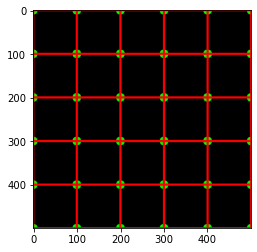

In [2]:
img = np.zeros((500, 500, 3), dtype = np.uint8)
for h in range(0, 501, 100):
    for w in range(0, 501, 100):
        cv2.circle(img, (w, h), 10, (0, 255, 0), -1)
        cv2.line(img, (0, h), (500, h), (255, 0, 0), 3)
        cv2.line(img, (w, 0), (w, 500), (255, 0, 0), 3)

plt.imshow(img);

## 1. Affine transformation
A `2D affine transformation` has the following form:

        X = a0*x + a1*y + a2 =
          = sx*x*cos(rotation) - sy*y*sin(rotation + shear) + a2

        Y = b0*x + b1*y + b2 =
          = sx*x*sin(rotation) + sy*y*cos(rotation + shear) + b2

### 1.1. Using `skimage`

#### Example 1. Fixed `scale = (1, 1), shear = 0.7` and `rotation`; change `translation` 

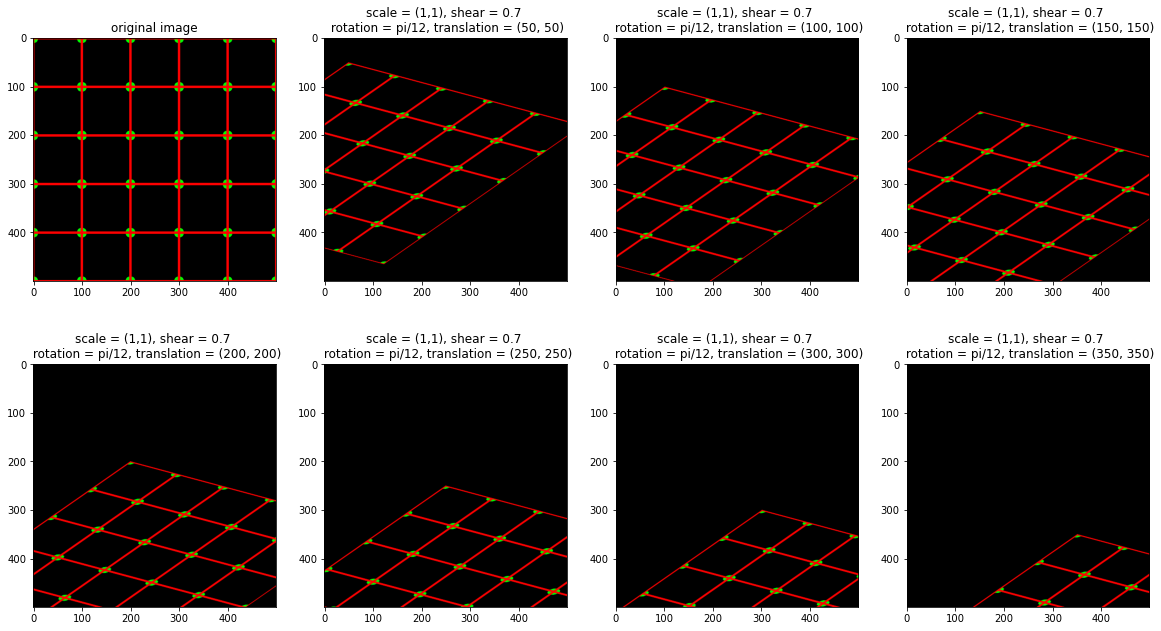

In [3]:
pi = np.pi
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 11))
ax = ax.ravel()
for k in range(8):
    if k == 0:
        ax[k].imshow(img); ax[k].set_title('original image')
    else:    
        tform = st.AffineTransform(scale=(1, 1), rotation = (pi/12) , shear=0.7, translation = (50*k, 50*k))
        out = st.warp(img, tform.inverse,output_shape = img.shape[:2])
        ax[k].imshow(out)
        ax[k].set_title('scale = (1,1), shear = 0.7 \n rotation = pi/12, translation = (%s, %s)'%(50*k, 50*k))

#### Example 2. Change `shear` and `scale`

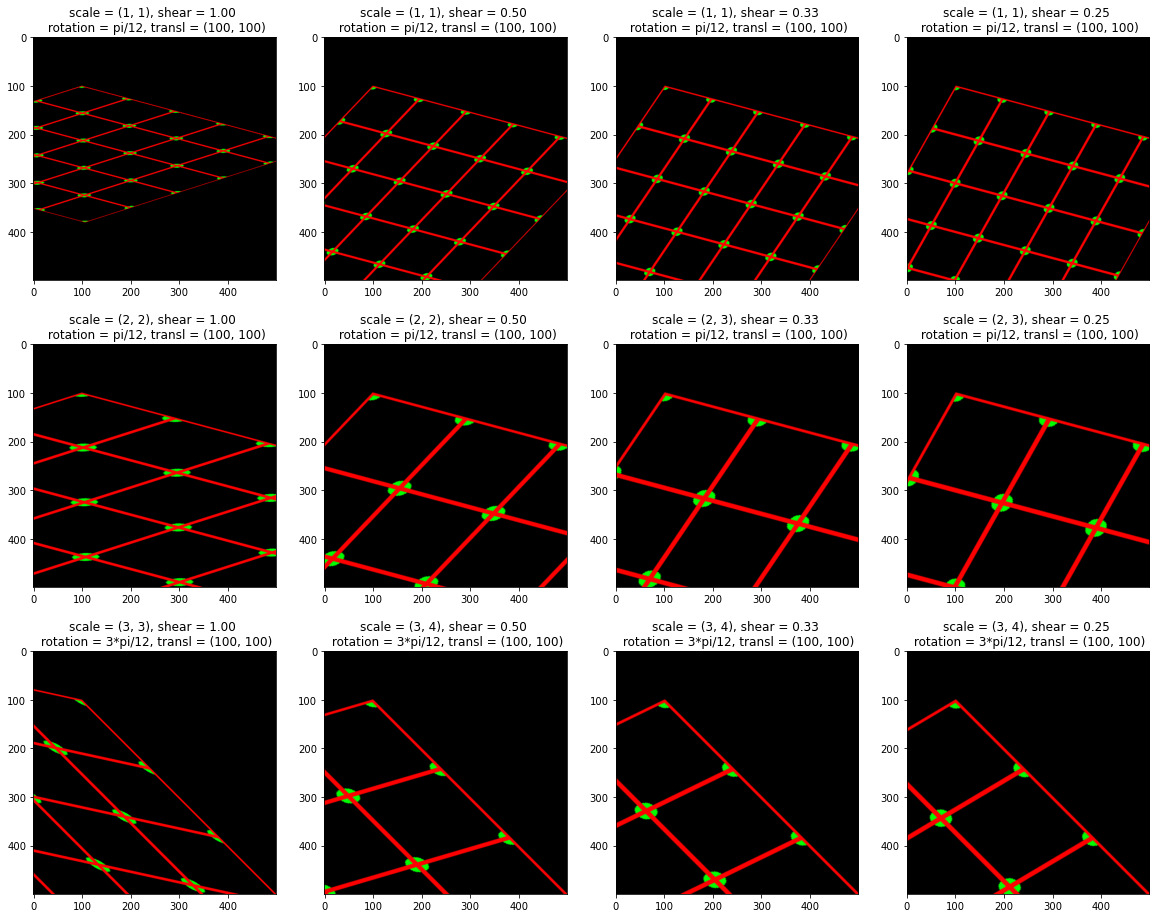

In [4]:
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (20, 16))
ax = ax.ravel()
for k in range(12):
    if k < 4:
        tform = st.AffineTransform(scale=(k//4 + 1, k//4 + 1), rotation = (pi/12) , shear = (1/(k+1)), translation = (100, 100))
        out = st.warp(img, tform.inverse,output_shape = img.shape[:2])
        ax[k].imshow(out)
        ax[k].set_title('scale = (%s, %s), shear = %.2f \n rotation = pi/12, transl = (100, 100)'%(k//4 + 1, k//4 + 1, 1/(k+1)))
    elif k < 8:
        tform = st.AffineTransform(scale=(k//4 + 1, k//4 + 1), rotation = (pi/12) , shear = (1/(k-3)), translation = (100, 100))
        out = st.warp(img, tform.inverse,output_shape = img.shape[:2])
        ax[k].imshow(out)
        ax[k].set_title('scale = (%s, %s), shear = %.2f \n rotation = pi/12, transl = (100, 100)'%(k//4 + 1, k//3 + 1, 1/(k-3)))
    else:
        tform = st.AffineTransform(scale=(k//4, k//4), rotation = ((k//4 + 1)*pi/12) , shear = (1/(k-7)), translation = (100, 100))
        out = st.warp(img, tform.inverse,output_shape = img.shape[:2])
        ax[k].imshow(out)
        ax[k].set_title('scale = (%s, %s), shear = %.2f \n rotation = %s*pi/12, transl = (100, 100)'%
                        (k//4 + 1, k//3 + 1, 1/(k-7), (k//4 + 1)))

#### Example 3. Fixed `translation = (100, 100)` and `scale = (1, 1)`; change `rotation, shear`

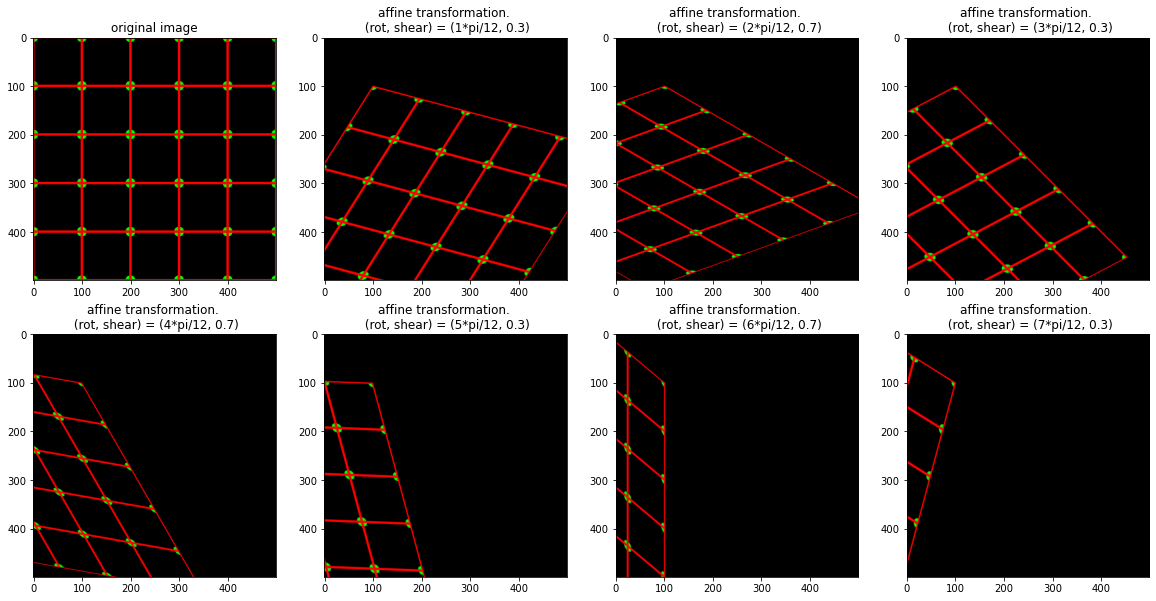

In [5]:
image = img
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
ax = ax.ravel()
for k in range(8):
    if k == 0:
        ax[k].imshow(image); ax[k].set_title('original image')
    else:
        tform = st.AffineTransform(scale=(1, 1), rotation = (k*pi/12) , shear=(0.7*(k%2==0) + 0.3*(k%2==1)), translation=(100, 100))
        out = st.warp(image, tform.inverse,output_shape=image.shape[:2])
        ax[k].imshow(out); ax[k].set_title('affine transformation. \n (rot, shear) = (%s*pi/%s, %s)'%(k, 12, (0.7*(k%2==0) + 0.3*(k%2==1))))

### 1.2. Using `OpenCV`.
From the preceding equation (mentioned in the introduction), then in `OpenCV` we need 3 pairs of point to create the `matrix-affine-transformation`

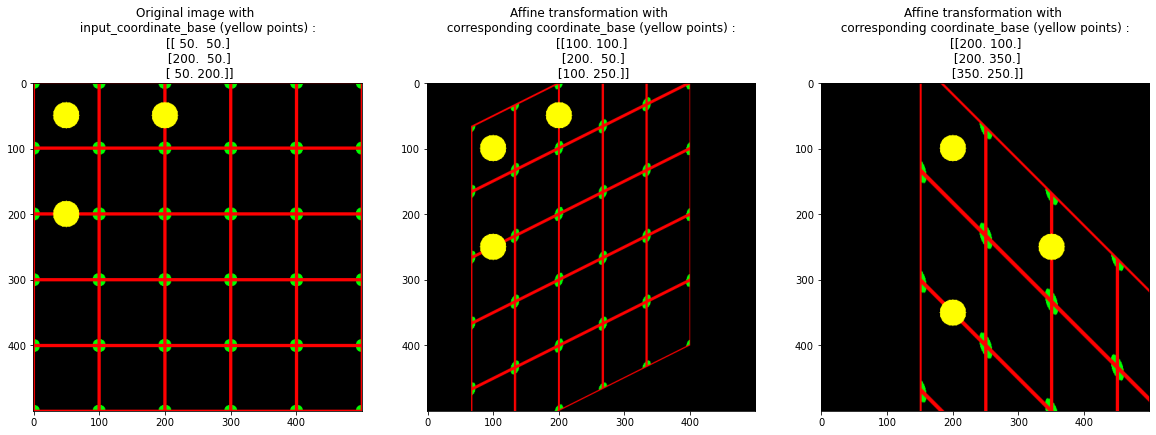

In [6]:
w, h = img.shape[:2]
image = img.copy()
pts1 = np.float32([[50,50], [200,50], [50,200]])
pts2 = np.float32([[100,100], [200,50], [100,250]])
pts3 = np.float32([[200,100], [200,350], [350,250]])

M12 = cv2.getAffineTransform(pts1, pts2); dst_12 = cv2.warpAffine(img,M12, (h, w))
M13 = cv2.getAffineTransform(pts1, pts3); dst_13 = cv2.warpAffine(img,M13, (h, w))

images = [image, dst_12, dst_13]
pts_s = [pts1, pts2, pts3]
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 7))
for k in range(3):    
    for cen in pts_s[k]:
        rx, ry = cen
        cv2.circle(images[k], (rx, ry), 20, (255, 255, 0), -1)
    ax[k].imshow(images[k]), 
    if k == 0:
        ax[k].set_title('Original image with \n input_coordinate_base (yellow points) : \n%s'%pts_s[k])
    else:
        ax[k].set_title('Affine transformation with \n corresponding coordinate_base (yellow points) : \n%s'%pts_s[k])

## 2. Pointwise-affine transformation
In `Python`, you can do this transformation easily by using `skimage.transform.PiecewiseAffineTransform`

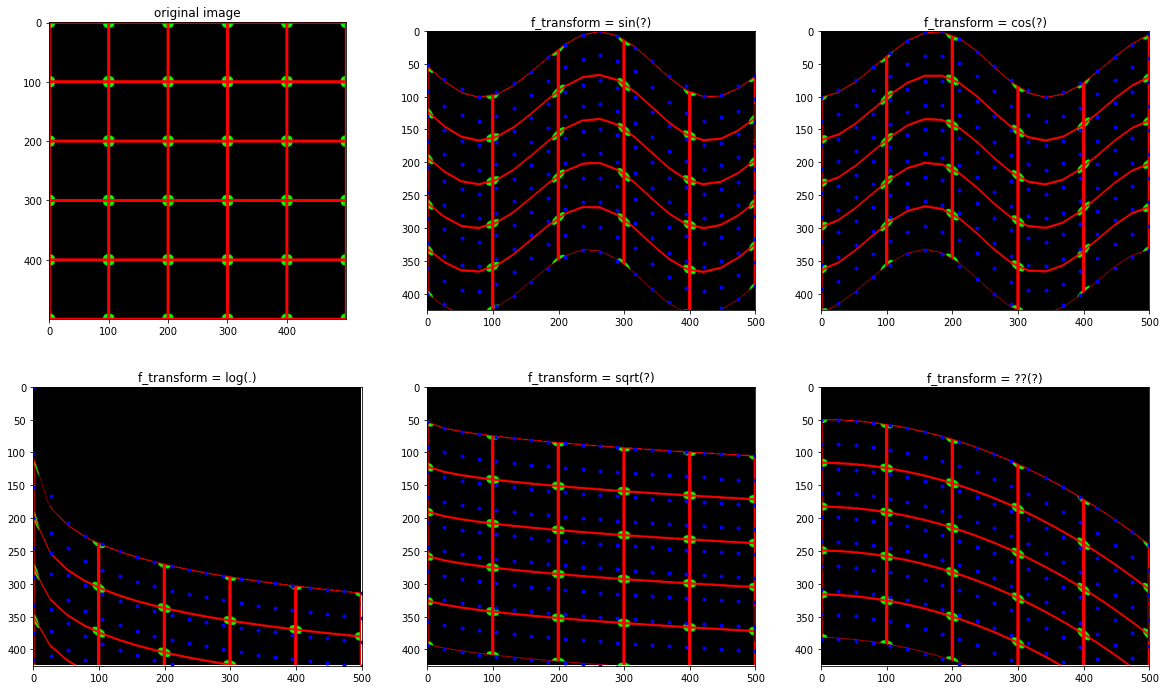

In [7]:
image = img.copy()
rows, cols = image.shape[0], image.shape[1]
titles = ['original image', 'f_transform = sin(?)', 'f_transform = cos(?)', 
          'f_transform = log(.)', 'f_transform = sqrt(?)', 'f_transform = ??(?)']

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 12))
ax = ax.ravel()
for k in range(6):
    ax[k].set_title(titles[k])
    if k == 0:
        ax[k].imshow(img) 
    else:
        src_cols = np.linspace(0, cols, 20)
        src_rows = np.linspace(0, rows, 10)
        src_rows, src_cols = np.meshgrid(src_rows, src_cols)
        src = np.dstack([src_cols.flat, src_rows.flat])[0]
        # add sinusoidal oscillation to row coordinates; all of them would be multiplied with 50
        if k == 1:
            dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 2:
            dst_rows = src[:, 1] - np.cos(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 3:
            dst_rows = src[:, 1] - np.log(1 + np.linspace(0, src.shape[0], src.shape[0])) * 50
        elif k == 4:
            dst_rows = src[:, 1] - 4*np.sqrt(np.linspace(0, src.shape[0], src.shape[0]))
        else:
            dst_rows = src[:, 1] - (np.linspace(0, src.shape[0], src.shape[0]))**2/200
        dst_cols = src[:, 0]
        dst_rows *= 1.5
        dst_rows -= 1.5 * 50
        dst = np.vstack([dst_cols, dst_rows]).T
        ## piecewise-transform
        tform = st.PiecewiseAffineTransform()
        tform.estimate(src, dst)
        ## warp
        out_rows = image.shape[0] - 1.5 * 50
        out_cols = cols
        out = st.warp(image, tform, output_shape=(out_rows, out_cols))
        
        ax[k].imshow(out)
        ax[k].plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.b')
        ax[k].axis((0, out_cols, out_rows, 0))

### Real-image illustration.

#### Example 2.1.

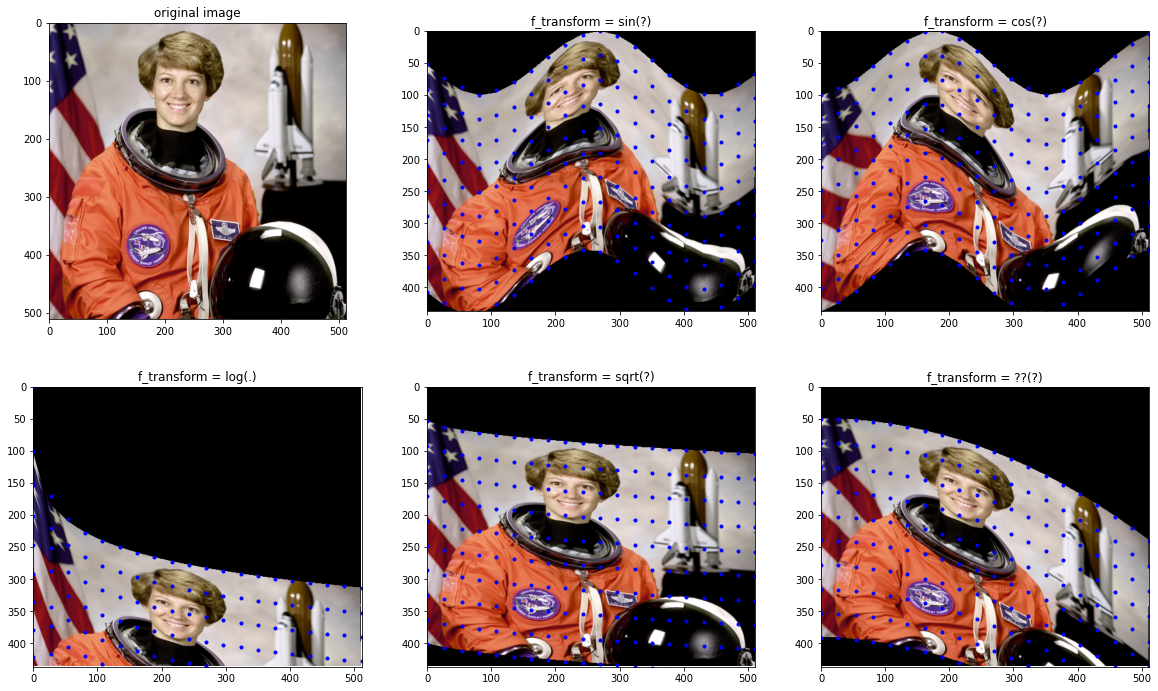

In [8]:
from skimage import data

image = data.astronaut()
rows, cols = image.shape[0], image.shape[1]
titles = ['original image', 'f_transform = sin(?)', 'f_transform = cos(?)', 
          'f_transform = log(.)', 'f_transform = sqrt(?)', 'f_transform = ??(?)']

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 12))
ax = ax.ravel()
for k in range(6):
    ax[k].set_title(titles[k])
    if k == 0:
        ax[k].imshow(image) 
    else:
        src_cols = np.linspace(0, cols, 20)
        src_rows = np.linspace(0, rows, 10)
        src_rows, src_cols = np.meshgrid(src_rows, src_cols)
        src = np.dstack([src_cols.flat, src_rows.flat])[0]
        # add sinusoidal oscillation to row coordinates; all of them would be multiplied with 50
        if k == 1:
            dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 2:
            dst_rows = src[:, 1] - np.cos(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 3:
            dst_rows = src[:, 1] - np.log(1 + np.linspace(0, src.shape[0], src.shape[0])) * 50
        elif k == 4:
            dst_rows = src[:, 1] - 4*np.sqrt(np.linspace(0, src.shape[0], src.shape[0]))
        else:
            dst_rows = src[:, 1] - (np.linspace(0, src.shape[0], src.shape[0]))**2/200
        dst_cols = src[:, 0]
        dst_rows *= 1.5
        dst_rows -= 1.5 * 50
        dst = np.vstack([dst_cols, dst_rows]).T
        ## piecewise-transform
        tform = st.PiecewiseAffineTransform()
        tform.estimate(src, dst)
        ## warp
        out_rows = image.shape[0] - 1.5 * 50
        out_cols = cols
        out = st.warp(image, tform, output_shape=(out_rows, out_cols))
        
        ax[k].imshow(out)
        ax[k].plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.b')
        ax[k].axis((0, out_cols, out_rows, 0))

#### Example 2.2.

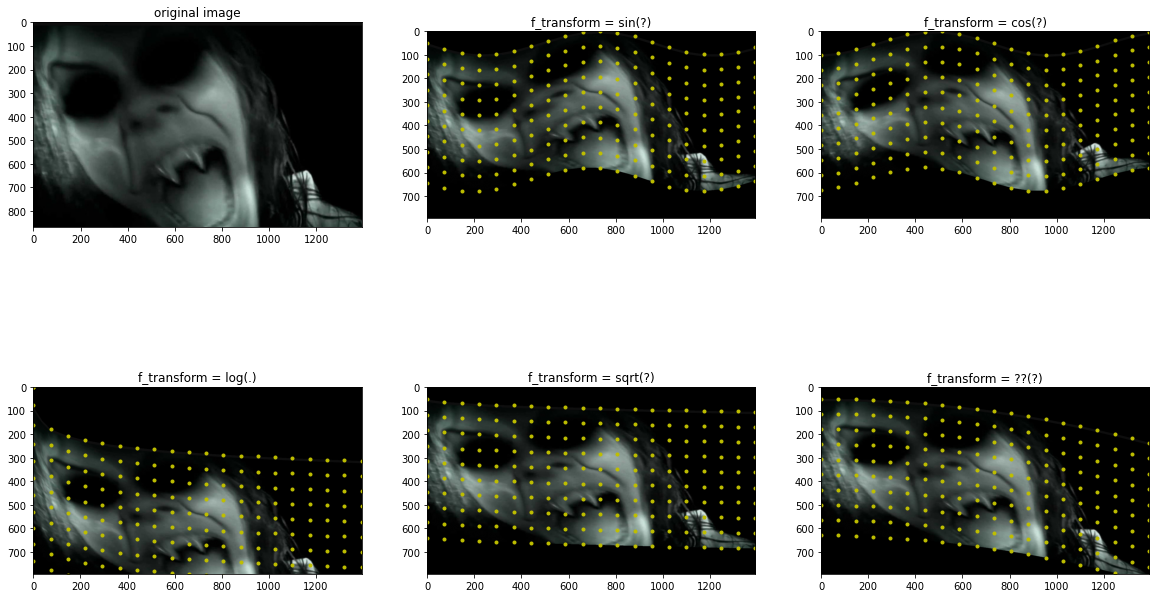

In [9]:
image = si.imread(r'../input/horrnor/screen_shoot_9.jpg')

rows, cols = image.shape[0], image.shape[1]
titles = ['original image', 'f_transform = sin(?)', 'f_transform = cos(?)', 
          'f_transform = log(.)', 'f_transform = sqrt(?)', 'f_transform = ??(?)']

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 12))
ax = ax.ravel()
for k in range(6):
    ax[k].set_title(titles[k])
    if k == 0:
        ax[k].imshow(image) 
    else:
        src_cols = np.linspace(0, cols, 20)
        src_rows = np.linspace(0, rows, 10)
        src_rows, src_cols = np.meshgrid(src_rows, src_cols)
        src = np.dstack([src_cols.flat, src_rows.flat])[0]
        # add sinusoidal oscillation to row coordinates; all of them would be multiplied with 50
        if k == 1:
            dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 2:
            dst_rows = src[:, 1] - np.cos(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 3:
            dst_rows = src[:, 1] - np.log(1 + np.linspace(0, src.shape[0], src.shape[0])) * 50
        elif k == 4:
            dst_rows = src[:, 1] - 4*np.sqrt(np.linspace(0, src.shape[0], src.shape[0]))
        else:
            dst_rows = src[:, 1] - (np.linspace(0, src.shape[0], src.shape[0]))**2/200
        dst_cols = src[:, 0]
        dst_rows *= 1.5
        dst_rows -= 1.5 * 50
        dst = np.vstack([dst_cols, dst_rows]).T
        ## piecewise-transform
        tform = st.PiecewiseAffineTransform()
        tform.estimate(src, dst)
        ## warp
        out_rows = image.shape[0] - 1.5 * 50
        out_cols = cols
        out = st.warp(image, tform, output_shape=(out_rows, out_cols))
        
        ax[k].imshow(out)
        ax[k].plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.y')
        ax[k].axis((0, out_cols, out_rows, 0))

#### Example 2.3.

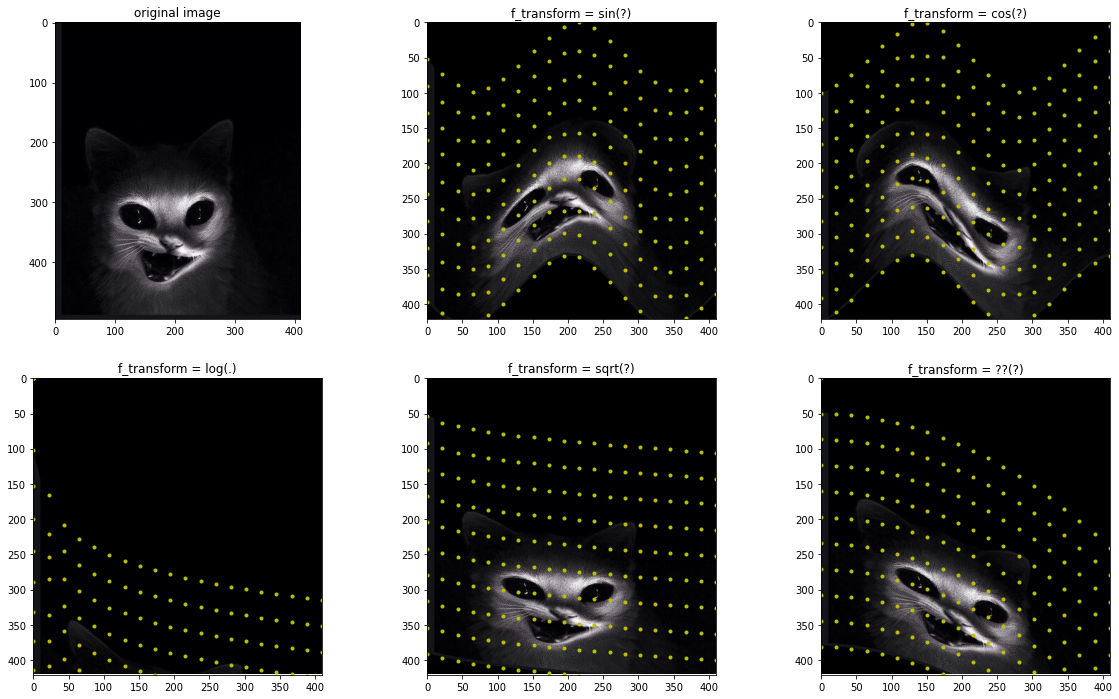

In [10]:
image = si.imread(r'../input/horrnor/screen_shoot_8.jpg')

rows, cols = image.shape[0], image.shape[1]
titles = ['original image', 'f_transform = sin(?)', 'f_transform = cos(?)', 
          'f_transform = log(.)', 'f_transform = sqrt(?)', 'f_transform = ??(?)']

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 12))
ax = ax.ravel()
for k in range(6):
    ax[k].set_title(titles[k])
    if k == 0:
        ax[k].imshow(image) 
    else:
        src_cols = np.linspace(0, cols, 20)
        src_rows = np.linspace(0, rows, 10)
        src_rows, src_cols = np.meshgrid(src_rows, src_cols)
        src = np.dstack([src_cols.flat, src_rows.flat])[0]
        # add sinusoidal oscillation to row coordinates; all of them would be multiplied with 50
        if k == 1:
            dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 2:
            dst_rows = src[:, 1] - np.cos(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 3:
            dst_rows = src[:, 1] - np.log(1 + np.linspace(0, src.shape[0], src.shape[0])) * 50
        elif k == 4:
            dst_rows = src[:, 1] - 4*np.sqrt(np.linspace(0, src.shape[0], src.shape[0]))
        else:
            dst_rows = src[:, 1] - (np.linspace(0, src.shape[0], src.shape[0]))**2/200
        dst_cols = src[:, 0]
        dst_rows *= 1.5
        dst_rows -= 1.5 * 50
        dst = np.vstack([dst_cols, dst_rows]).T
        ## piecewise-transform
        tform = st.PiecewiseAffineTransform()
        tform.estimate(src, dst)
        ## warp
        out_rows = image.shape[0] - 1.5 * 50
        out_cols = cols
        out = st.warp(image, tform, output_shape=(out_rows, out_cols))
        
        ax[k].imshow(out)
        ax[k].plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.y')
        ax[k].axis((0, out_cols, out_rows, 0))

#### Example 2.4.

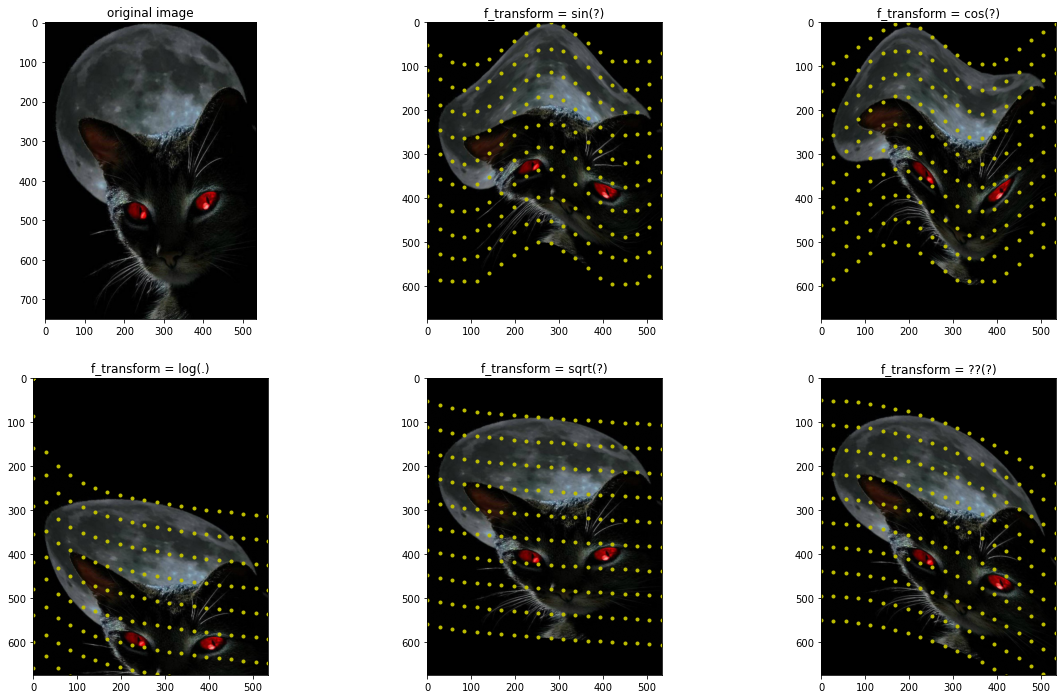

In [11]:
image = si.imread(r'../input/horrnor/screen_shoot_7.jpg')

rows, cols = image.shape[0], image.shape[1]
titles = ['original image', 'f_transform = sin(?)', 'f_transform = cos(?)', 
          'f_transform = log(.)', 'f_transform = sqrt(?)', 'f_transform = ??(?)']

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 12))
ax = ax.ravel()
for k in range(6):
    ax[k].set_title(titles[k])
    if k == 0:
        ax[k].imshow(image) 
    else:
        src_cols = np.linspace(0, cols, 20)
        src_rows = np.linspace(0, rows, 10)
        src_rows, src_cols = np.meshgrid(src_rows, src_cols)
        src = np.dstack([src_cols.flat, src_rows.flat])[0]
        # add sinusoidal oscillation to row coordinates; all of them would be multiplied with 50
        if k == 1:
            dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 2:
            dst_rows = src[:, 1] - np.cos(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
        elif k == 3:
            dst_rows = src[:, 1] - np.log(1 + np.linspace(0, src.shape[0], src.shape[0])) * 50
        elif k == 4:
            dst_rows = src[:, 1] - 4*np.sqrt(np.linspace(0, src.shape[0], src.shape[0]))
        else:
            dst_rows = src[:, 1] - (np.linspace(0, src.shape[0], src.shape[0]))**2/200
        dst_cols = src[:, 0]
        dst_rows *= 1.5
        dst_rows -= 1.5 * 50
        dst = np.vstack([dst_cols, dst_rows]).T
        ## piecewise-transform
        tform = st.PiecewiseAffineTransform()
        tform.estimate(src, dst)
        ## warp
        out_rows = image.shape[0] - 1.5 * 50
        out_cols = cols
        out = st.warp(image, tform, output_shape=(out_rows, out_cols))
        
        ax[k].imshow(out)
        ax[k].plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.y')
        ax[k].axis((0, out_cols, out_rows, 0))